In [1]:
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore",category=np.VisibleDeprecationWarning)

dataset = np.loadtxt("./features.txt", delimiter=" ");
print(dataset.shape)



(52580, 36)


In [2]:
import tensorflow as tf

num_features = 35
batch_size = 256
test_size = 2000
num_hidden_nodes1 = 4096
num_hidden_nodes2 = 2048
num_labels = 2

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float64, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float64, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float64, shape=(test_size, num_features))
    tf_test_dataset = tf.placeholder(tf.float64, shape=(test_size, num_features))
    beta_regul = tf.placeholder(tf.float64)
    global_step = tf.Variable(0)
    
    weights1 = tf.Variable(
    tf.truncated_normal(
        [num_features, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (num_features)), dtype=tf.float64), dtype=tf.float64
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1], dtype=tf.float64), dtype=tf.float64)
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                        stddev=np.sqrt(2.0 / num_hidden_nodes1), 
                        dtype=tf.float64),
    dtype=tf.float64)
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2], dtype=tf.float64), dtype=tf.float64)
    weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], 
                        stddev=np.sqrt(2.0 / num_hidden_nodes2),
                        dtype=tf.float64),
    dtype=tf.float64)
    biases3 = tf.Variable(tf.zeros([num_labels], dtype=tf.float64), dtype=tf.float64)
    
    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(lay2_train, 0.5)
    logits = tf.matmul(drop2, weights3) + biases3
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
        
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

        

In [3]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])


In [4]:
valid_start_index = 0
valid_end_index = 1000
test_start_index = 1000
test_end_index = 2000

class Dataset:
    
    def __init__(self, dataset):
        np.random.shuffle(dataset)

        botnetDataset = dataset[dataset[:,35]==1, :]
        normalDataset = dataset[dataset[:,35]==0, :]

        botnetX = botnetDataset[:,:35]
        normalX = normalDataset[:,:35]
        
        self.botnetY = botnetDataset[:, 35]
        self.normalY = normalDataset[:, 35]

        scaler = MinMaxScaler(feature_range=(0, 1))
        self.rescaledBotnetX = scaler.fit_transform(botnetX)
        self.rescaledNormalX = scaler.fit_transform(normalX)
        
    def getTrainingDataSet(self):
        return self.rescaledBotnetX[test_end_index:,:], self.rescaledNormalX[test_end_index:,:], \
    self.botnetY[test_end_index:], self.normalY[test_end_index:]
    
    def getValidationDataSet(self):
        validation_dataset = np.concatenate((self.rescaledBotnetX[valid_start_index:valid_end_index,:], 
                                         self.rescaledNormalX[valid_start_index:valid_end_index,:]))
        valid_labels = np.concatenate((self.botnetY[valid_start_index:valid_end_index], 
                                       self.normalY[valid_start_index:valid_end_index]))
        valid_labels = (np.arange(num_labels) == valid_labels[:,None]).astype(np.float64)
        return validation_dataset, valid_labels
        
    def getTestingDataSet(self):
        test_dataset = np.concatenate((self.rescaledBotnetX[test_start_index:test_end_index,:], 
                                   self.rescaledNormalX[test_start_index:test_end_index,:]))
        test_labels = np.concatenate((self.botnetY[test_start_index:test_end_index], 
                                 self.normalY[test_start_index:test_end_index]))
        test_labels = (np.arange(num_labels) == test_labels[:,None]).astype(np.float64)
        return test_dataset, test_labels

In [5]:
regul_val = [pow(10, i) for i in np.arange( -4, -2, 0.1)]
accuracy_val = []
num_steps = 250
class_batch_size = int(batch_size)/2

datasetHelper = Dataset(dataset)
valid_dataset, valid_labels = datasetHelper.getValidationDataSet()
test_dataset, test_labels = datasetHelper.getTestingDataSet()
trainBotnetX, trainNormalX, trainBotnetY, trainNormalY = datasetHelper.getTrainingDataSet()

for regul in regul_val:
    offset = 0
    with tf.Session(graph=graph) as session:

        tf.global_variables_initializer().run()
        for step in range(num_steps):
            np.random.shuffle(trainNormalX)
            train_batch_data = np.concatenate((trainBotnetX[offset:(offset+class_batch_size),:], 
                                   trainNormalX[:class_batch_size,:]))
            train_batch_labels = np.concatenate((trainBotnetY[:class_batch_size], 
                                 trainNormalY[:class_batch_size]))
            train_batch_labels = (np.arange(num_labels) == train_batch_labels[:,None]).astype(np.float64)
            offset = offset + class_batch_size

            feed_dict = {tf_train_dataset : train_batch_data, 
                         tf_train_labels : train_batch_labels,
                         tf_valid_dataset : valid_dataset,
                         tf_test_dataset : test_dataset,
                         beta_regul : regul
                        }
            
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        feed_dict = { tf_test_dataset : test_dataset,
                      beta_regul : 3e-4 }
        print("Test accuracy for regularization param %.6f : %.1f%%" % (regul, accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels)))
        accuracy_val.append(accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))
        
print(accuracy_val)

Test accuracy for regularization param 0.000100 : 86.5%
Test accuracy for regularization param 0.000126 : 87.3%
Test accuracy for regularization param 0.000158 : 84.8%
Test accuracy for regularization param 0.000200 : 86.1%
Test accuracy for regularization param 0.000251 : 87.7%
Test accuracy for regularization param 0.000316 : 87.3%
Test accuracy for regularization param 0.000398 : 56.4%
Test accuracy for regularization param 0.000501 : 59.5%
Test accuracy for regularization param 0.000631 : 87.1%
Test accuracy for regularization param 0.000794 : 87.2%
Test accuracy for regularization param 0.001000 : 87.1%
Test accuracy for regularization param 0.001259 : 84.6%
Test accuracy for regularization param 0.001585 : 84.2%
Test accuracy for regularization param 0.001995 : 88.2%
Test accuracy for regularization param 0.002512 : 87.5%
Test accuracy for regularization param 0.003162 : 86.9%
Test accuracy for regularization param 0.003981 : 85.2%
Test accuracy for regularization param 0.005012 

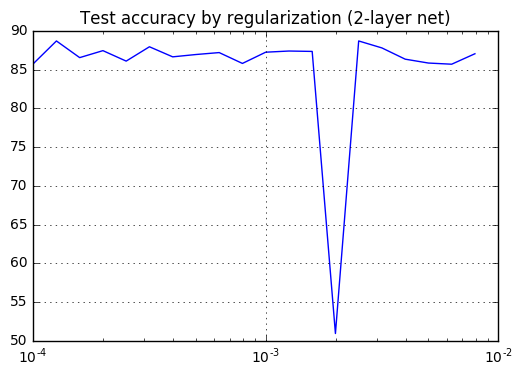

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (2-layer net)')
plt.show()

In [36]:
test_accuracy = []
for cross_validation in range(10):
    
    offset = 0
    datasetHelper = Dataset(dataset)
    valid_dataset, valid_labels = datasetHelper.getValidationDataSet()
    test_dataset, test_labels = datasetHelper.getTestingDataSet()
    trainBotnetX, trainNormalX, trainBotnetY, trainNormalY = datasetHelper.getTrainingDataSet()
    
    with tf.Session(graph=graph) as session:

        tf.global_variables_initializer().run()
        for step in range(num_steps):
            np.random.shuffle(trainNormalX)
            train_batch_data = np.concatenate((trainBotnetX[offset:(offset+class_batch_size),:], 
                                   trainNormalX[:class_batch_size,:]))
            train_batch_labels = np.concatenate((trainBotnetY[:class_batch_size], 
                                 trainNormalY[:class_batch_size]))
            train_batch_labels = (np.arange(num_labels) == train_batch_labels[:,None]).astype(np.float64)
            offset = offset + class_batch_size

            feed_dict = {tf_train_dataset : train_batch_data, 
                         tf_train_labels : train_batch_labels,
                         tf_valid_dataset : valid_dataset,
                         tf_test_dataset : test_dataset,
                         beta_regul : 6e-4
                        }
            
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        feed_dict = { tf_test_dataset : test_dataset,
                      beta_regul : 3e-4 }
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))
        test_accuracy.append(accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))
        
print("Average Test Accuracy over 10 folds with regularization param 6e-4: %.2f" % (np.mean(test_accuracy)))

Test accuracy: 86.5%
Test accuracy: 86.7%
Test accuracy: 85.0%
Test accuracy: 85.9%
Test accuracy: 87.1%
Test accuracy: 89.0%
Test accuracy: 88.8%
Test accuracy: 86.7%
Test accuracy: 86.8%
Test accuracy: 87.3%
Average Test Accuracy over 10 folds with regularization param 6e-4: 86.97


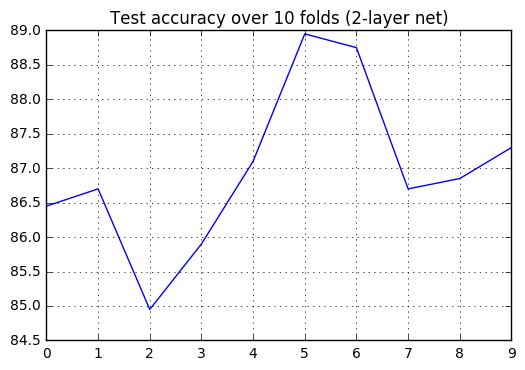

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array(np.arange(0, 10, 1))
y = np.array(test_accuracy)
plt.plot(x, y)
plt.grid(True)
plt.title('Test accuracy over 10 folds (2-layer net)')
plt.show()